# 第一步 导入图片数据


Found 6 images belonging to 2 classes.
Found 10 images belonging to 3 classes.


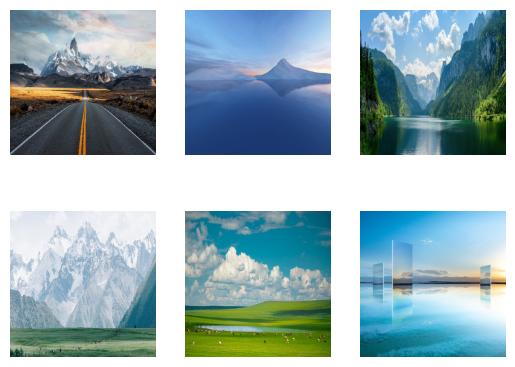

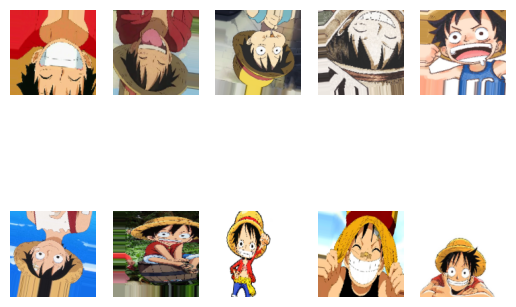

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator    #从tensorflow中导入ImageDataGenerator
import numpy as np                                                     #导入numpy并命名np
from matplotlib import pyplot as plt
IMSIZE=128       #定义图片尺寸
sample_size=1000 #定义样本大小

"""从文件夹中提取背景图片为background，提取头像为head，通过ImageDataGenerator功能，可以随机抽取并转换成指定大小，还可以设置图片的增强改变，但需要图像文件夹中要有子文件夹，不然读取不了"""
background_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(     #此处的ImageDataGenerator可以对图像做增强，可以直接将图像归一化
    './lesson4/background',                                                        #选择读取图片的文件夹
    target_size=(4*IMSIZE, 4*IMSIZE),                                              #读取文件后可以直接将图片的尺寸进行修改
    batch_size=6,                                                                  #设定一次读取的batch大小，因为只有6张图，所以随机排序读取6张，后面再进行裁剪随机增加背景数量
    class_mode='categorical')                                                      #此处定义为分类数据，则可在不同文件夹中读取图片
head_generator = ImageDataGenerator(                                               #此处的ImageDataGenerator加入了图像增强，在有限的头像（10张）数据中，对其进行各种改变的增强以增加数据
    rescale=1./255,                                                                #归一化
    shear_range=0.2,                                                               #裁剪尺度从0到20%
    rotation_range=10,                                                             #旋转角度从-10到10度
    zoom_range=0.2,                                                                #缩放比例从80%到120%
    width_shift_range=0.2,                                                         #水平平移-20%到20%
    height_shift_range=0.2,                                                        #上下平移-20%到20%
    horizontal_flip=True,                                                          #左右翻转
    vertical_flip=True                                                             #上下翻转
    ).flow_from_directory(                                                         
    "./lesson4/head",                                                              #读取路径
    target_size=(IMSIZE, IMSIZE),                                                  #读取后规定尺寸
    batch_size=10,                                                                 #10张图
    class_mode='categorical'                                                       #分类数据
    )

"""准备好图像数据与分类值数据存储用的变量"""
X0 = np.zeros([sample_size,2*IMSIZE,2*IMSIZE,3])                                   #无头像图片
Y0 = np.zeros([sample_size,2])                                                     #无头像分类值
X1 = np.zeros([sample_size,2*IMSIZE,2*IMSIZE,3])                                   #有头像图片
Y1 = np.zeros([sample_size,2])                                                     #有头像分类值

"""展示背景图片与图像增强的头像"""
B = next(background_generator)[0]
fig,ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(2*3):
    ax[i].imshow(B[i])
    ax[i].axis("off")
    
H = next(head_generator)[0]

fig,ax = plt.subplots(2,5)
ax = ax.flatten()

for i in range(2*5):
    ax[i].imshow(H[i])
    ax[i].axis("off")

# 第二步 生成合成数据

(256, 256, 3) (256, 256, 3)


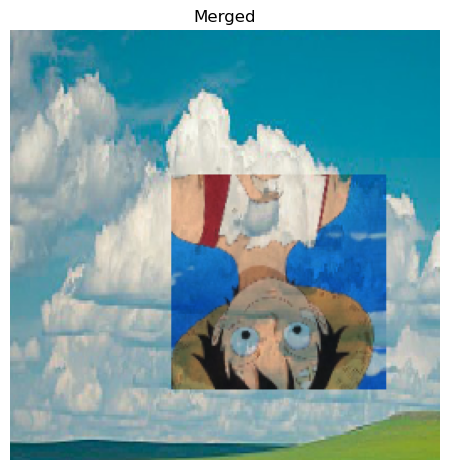

In [20]:
face_size = IMSIZE      #定义头像的尺寸为IMSIZE

for i in range(sample_size):                                                  #通过循环，将背景图片随机裁剪作为背景，将随机增强的头像作为头像，并合成新的头像与背景的图像
      xx0=np.random.randint(0,4*IMSIZE-2*face_size);xx1=xx0+2*face_size
      yy0=np.random.randint(0,4*IMSIZE-2*face_size);yy1=yy0+2*face_size
      x0=np.random.randint(0,2*IMSIZE-face_size);x1=x0+face_size
      y0=np.random.randint(0,2*IMSIZE-face_size);y1=y0+face_size
      aa = next(background_generator)
      bb = next(head_generator)
      X0[i,:,:,:] = aa[0][0,xx0:xx1,yy0:yy1,:];Y0[i,0]=1;Y0[i,1]=0                                                    #无头像的哑变量是【10】
      X1[i,:,:,:] = aa[0][0,xx0:xx1,yy0:yy1,:];X1[i,x0:x1,y0:y1,:]=X1[i,x0:x1,y0:y1,:]*bb[0][0] ;Y1[i,0]=0;Y1[i,1]=1  #有头像的哑变量是【01】

"""检查合成后的数据格式与合成后的新图片"""
print(X0[0].shape,X1[0].shape)
plt.imshow(aa[0][0])
plt.imshow(X1[0])
plt.axis('off')
plt.title("Merged")
plt.tight_layout()
plt.show()

# 第三步 切割图片

(-0.5, 127.5, 127.5, -0.5)

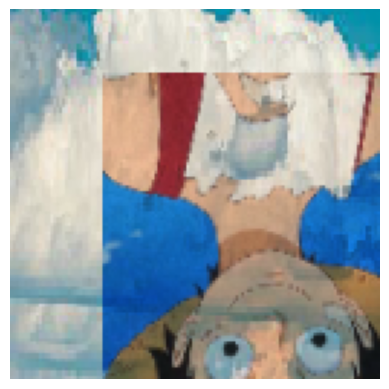

In [22]:
XX = np.vstack((X0,X1));YY = np.vstack((Y0,Y1))     #通过np的vstack功能将XO与X1数据合并成XX数据，Y0与Y1的数据合并成YY数据

"""设定中间区域坐标,并裁剪XX"""
xx0 = int(0.5*face_size);xx1 = xx0+face_size        
yy0 = int(0.5*face_size);yy1 = yy0+face_size
XX = XX[:,xx0:xx1,yy0:yy1,:]                  #  裁剪所有图片
"""检查裁剪结果"""
plt.imshow(XX[1000])
plt.axis("off")

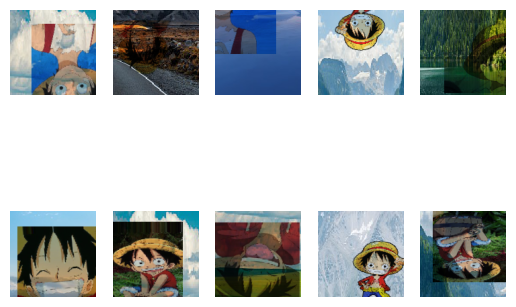

In [24]:
"""10张合成后、裁剪后的照片"""
XB = XX[1000:]
fig,ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(2*5):
    ax[i].imshow(XB[i])
    ax[i].axis("off")

# 第四步 随机split数据

In [23]:
from sklearn.model_selection import train_test_split                    #使用split功能随机平分训练集和测试集
XX0,XX1,YY0,YY1 = train_test_split(XX,YY,test_size=0.5,random_state=1)

# 第五步 搭建模型

In [27]:
from keras.layers import Dense,Flatten,Input,Activation,Conv2D        #导入必要功能
from keras.layers import MaxPooling2D,BatchNormalization
from keras import Model

ConLayer = 20                                                         #卷积层数
ConNumber = 3                                                         #卷积次数
NurNumber = 200                                                       #神经数量
DenNumber = 5                                                         #全连接层数量

input_size = [IMSIZE,IMSIZE,3]                                        #设定input与input_layer
input_layer = Input(input_size)                                       
x = input_layer
x = BatchNormalization()(x)                                           #标准化输入
for i in range(ConNumber):                                            #增加卷积层与池化层
    x = Conv2D(ConLayer,[5,5],padding='same',activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)                                                      #展平

for i in range(DenNumber):                                            #增加全链接层
    x = Dense(NurNumber,activation="relu")(x)

x = Dense(2,activation="softmax")(x)                                  #最后激活为两类softmax
output_layer = x
model = Model(input_layer, output_layer)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 20)     │        10,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 20)     │        10,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     1,024,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,974 (4.60 MB)

 Trainable params: 1,206,968 (4.60 MB)

 Non-trainable params: 6 (24.00 B)

### 模型解读（由上至下）  
#### 输入层为128x128的RGB彩色图片，无参数  
#### 标准化层，有3个平均值，3个方差，有3个α，有三个β，共计12个参数，其中前三个是非训练参数  
#### 卷积层，（5x5x3+1）x20 = 1520。每个卷积层是5x5，RGB三张图片，再加一个截距项，一共20张  
#### 池化层，无参数
#### 卷积层，（5x5x20+1）x20 = 10020。每个卷积层是5x5，池化后共20张，再加一个截距项，一共20个卷积层  
#### 池化层，无参数
#### 卷积层，（5x5x20+1）x20 = 10020。每个卷积层是5x5，池化后共20张，再加一个截距项，一共20个卷积层  
#### 池化层，无参数  
#### 展平层，无参数
#### 全连接层，（5120+1）x200 = 1024200。一共5120个输入，200个神经元，每个神经元有1个截距项  
#### 全连接层，（200+1）x200 = 40200.一共200个输入，200 个神经元，每个神经元有一个截距项
#### 全连接层，（200+1）x200 = 40200.一共200个输入，200 个神经元，每个神经元有一个截距项
#### 全连接层，（200+1）x200 = 40200.一共200个输入，200 个神经元，每个神经元有一个截距项
#### 全连接层，（200+1）x200 = 40200.一共200个输入，200 个神经元，每个神经元有一个截距项
#### 全连接层，（200+1）x2 = 402.一共200个输入，2 个神经元，每个神经元有一个截距项
#### 共计1206974个参数，其中6个是非训练参数

# 第六步 开始训练

In [37]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.000001),loss='categorical_crossentropy',metrics=['accuracy'])                     #学习率可调的Adam，交叉熵为损失函数，监控为准确率

from tensorflow.keras.callbacks import ModelCheckpoint                                                        #用checkpoint记录最优模型
checkpoint = ModelCheckpoint('model_new.h5', monitor='val_acc', verbose=1, save_best_only=True,mode='max')    #最优模型的存储文件名，监控是测试组的准确率，显示存储信息，并存储最大的模型


history = model.fit(XX0,YY0,                             #开始训练，训练集为XX0,YY0，验证集为XX1,YY1，batch为1000
          validation_data=(XX1,YY1),
          batch_size=1000,
          epochs=1,
          callbacks=[checkpoint]                         #    此处存储最优模型
          )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - loss: 2.4470e-06WARNING:tensorflow:5 out of the last 203 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x0000022159E2BF60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 2.4470e-06 - val_accuracy: 0.9720 - val_loss: 0.2086


# 第七步 检查精度

# 第七步 检查准确度

In [39]:
print(max(history.history["val_accuracy"]))      #打印最优预测精度

0.972000002861023


In [40]:
BigBackground = next(background_generator)[0][0]                                               #生成新的随机图片
bb0 = np.random.randint(0,4*IMSIZE-face_size);bb1 = bb0+face_size
cc0 = np.random.randint(0,4*IMSIZE-face_size);cc1 = cc0+face_size
BigBackground[bb0:bb1,cc0:cc1,:] = BigBackground[bb0:bb1,cc0:cc1,:]*next(head_generator)[0][0]  #合成任意头像加背景图片

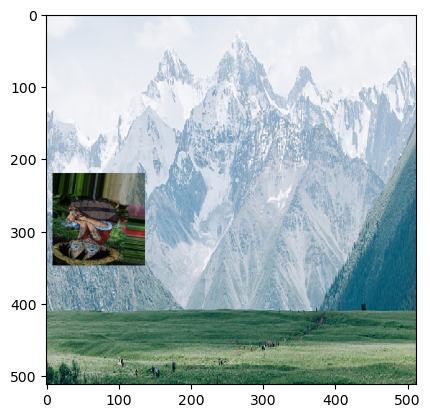

In [41]:
plt.imshow(BigBackground)               #图片合成效果

In [42]:
nx,ny,nz = BigBackground.shape                                    #随机取图片10的4次方个并存储位置信息
nsimu = 10**4
location = np.zeros([nsimu,2])
Z = np.zeros([nsimu,IMSIZE,IMSIZE,3])
for i in range(nsimu):
    x0 = np.random.randint(0,nx-IMSIZE); x1 = x0+IMSIZE
    y0 = np.random.randint(0,ny-IMSIZE); y1 = y0+IMSIZE
    Z[i] = BigBackground[x0:x1,y0:y1,:]
    location[i]=[x0,y0]


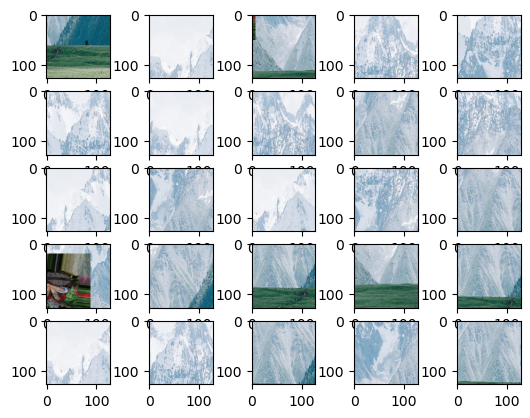

In [43]:
fig,ax = plt.subplots(5,5)   #检查随机图片
ax = ax.flatten()
for i in range(5*5):
    ax[i].imshow(Z[i])

In [44]:
from tensorflow.keras.models import load_model    #导入存储好的模型
PreModel = load_model('model_new.h5')
prob = PreModel.predict(Z)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


Text(0.5, 1.0, '1.0')

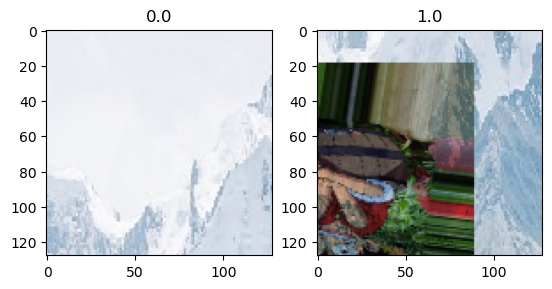

In [45]:
id0,id1 = np.argmax(prob,axis = 0)             #使用预测模型找出最值
fig,ax = plt.subplots(1,2)
ax[0].imshow(Z[id0]);ax[0].set_title(np.round(prob[id0,1]))
ax[1].imshow(Z[id1]);ax[1].set_title(np.round(prob[id1,1]))

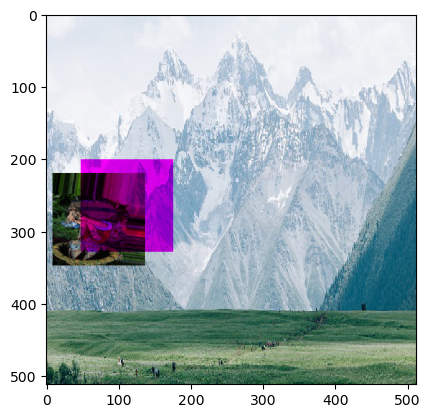

In [46]:
x0,y0 = location[id1]                         #在原图中标记出最可能的头像位置
x0=int(x0);y0=int(y0)
BigBackground[x0:x0+IMSIZE,y0:y0+IMSIZE,1]=0
plt.imshow(BigBackground)